In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.datasets import load_arrow_head
from sktime.series_as_features.compose import FeatureUnion
from sktime.transformers.series_as_features.compose import RowTransformer
from sktime.transformers.series_as_features.reduce import Tabularizer
from sktime.transformers.series_as_features.segment import \
    RandomIntervalSegmenter
from sktime.utils.time_series import time_series_slope
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
y = np.load("E:/y_cl.npy")
newy = np.zeros(len(y))
for i in range(len(y)):
    newy[i] = np.where(y[i]==1)[0][0]
    
y = pd.Series(newy)
print(y.shape)
inputLength = 760
x = pd.DataFrame(index=range(18955),columns=['dim_0'])
c = 0
for file in os.listdir('E:/sector_lightcurves/'):
    row = int(file.split('-')[0])
    with open('E:/sector_lightcurves/'+file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc = lc.remove_nans().remove_outliers(sigma=25)
    
    cut_std = np.std(lc.flux[:inputLength])
    flux = pd.Series(lc.flux[:inputLength]/cut_std)
    #flux = np.array([np.array([flux[i]]) for i in range(len(flux))])
    x.at[c,'dim_0'] = flux
    c = c + 1

x_train, x_test, y_train, y_test = train_test_split(x, y)

(18955,)


In [3]:
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor

steps = [
    ('extract', RandomIntervalFeatureExtractor(n_intervals='sqrt', features=[np.mean, np.std, time_series_slope])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)
tsf = TimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion='entropy',
    bootstrap=True,
    oob_score=True,
    random_state=1
)

tsf.fit(x_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)
y_pred = tsf.predict(x_test)

0.20216657287563308


In [6]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=9,metric="dtw")
knn.fit(x_train, y_train)
print("Model fitted")
print(knn.score(x_test, y_test))
#y_pred = tsf.predict(x_test)

Model fitted
0.19160160371386367


In [ ]:
knn.score(x_test, y_test)

[[  4   4  90 250 170  43]
 [  8   3  66 216 146  29]
 [ 17   7 110 373 270  54]
 [ 11  10 126 489 360 107]
 [  8  12 136 445 341  77]
 [  5   9  85 336 238  84]]


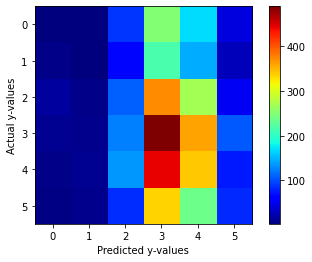

In [4]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm,cmap='jet')
plt.xlabel('Predicted y-values')
plt.ylabel('Actual y-values')
plt.colorbar()
plt.show()

In [51]:
counter = 0
for n in range(len(y_pred)):
    if y_pred[n] == y_test.iat[n]:
        counter = counter + 1
print(counter/len(y_test))

0.22008862629246675


In [6]:

tsf = TimeSeriesForestClassifier()
tsf.fit(x_train, y_train)
tsf.score(x_test, y_test)

0.21017092213547162

In [3]:
import keras

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`